In [32]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [33]:
EPOCHS = 3
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Device:", DEVICE)

Device: cpu


In [34]:
trainset = torchvision.datasets.FashionMNIST(
    "./.data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [35]:
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh()
)
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [36]:
D = D.to(DEVICE)
G = G.to(DEVICE)

In [37]:
criterion = nn.BCELoss()
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)

Epoch [0/3], d_loss: 0.0401, g_loss: 5.9195            D(x): 1.00, D(G(z)): 0.03
Epoch [1/3], d_loss: 0.1217, g_loss: 7.5888            D(x): 0.98, D(G(z)): 0.05
Epoch [2/3], d_loss: 0.0529, g_loss: 5.4127            D(x): 1.00, D(G(z)): 0.04


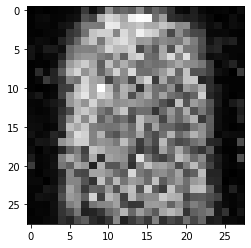

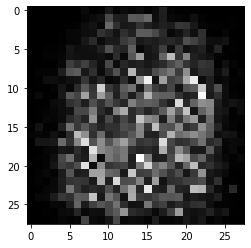

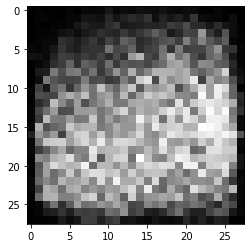

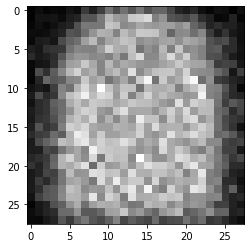

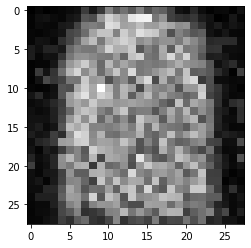

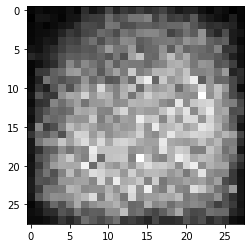

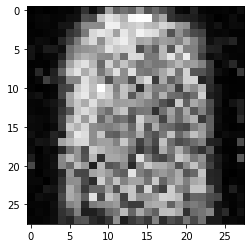

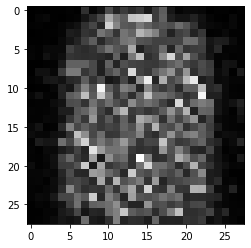

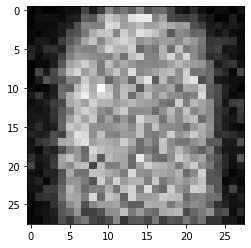

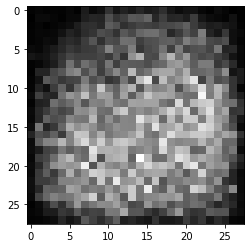

In [39]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        Z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(Z)
        
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        fake_images = G(Z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    
    print(f"Epoch [{epoch}/{EPOCHS}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}\
            D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}")

z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
fake_images_cpu = fake_images.data.cpu().numpy()
for i in range(10):
    fake_images_img = np.reshape(fake_images_cpu[i], (28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()